In [1]:
import os,sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

/home/artem/miniconda2/envs/datanight/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Загрузим данные
 * При первом запуске скачаем train.csv и evaluation.csv
 * При повторных запусках файлы уже будут на месте

In [12]:
evaluation_url = "https://www.dropbox.com/s/482zjl1hzgvej92/test.csv?dl=1"
training_url = "https://www.dropbox.com/s/4y54q61b6s18ofh/train.csv?dl=1"
evaluation_path = "test.csv"
training_path = "train.csv"

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

if not os.path.exists(evaluation_path):
    urlretrieve(evaluation_url,evaluation_path)
if not os.path.exists(training_path):
    urlretrieve(training_url,training_path)

In [2]:
data = pd.DataFrame.from_csv("./train.csv")

In [3]:
#Если у вас слабый компьютер - можно взять подвыборку данных
data = data[::5]

In [4]:
x_col = [ 'dist','due', 'lat','lon','f_class','s_class','t_class',]
X_raw = data[x_col]
y = data['burned'].values


# Простое решение
- Сделаем One-Hot encoding для всех категориальных фичей
- Научим Random Forest

### Предобработка данных

In [5]:
from sklearn.feature_extraction import DictVectorizer

#вытаскиватель категориальных фичей
vectorizer = DictVectorizer(sparse=False,dtype=np.bool)

def preprocess_data(X_raw):
    data_dict = [ {'f_class':f,'s_class':s,'t_class':t}
               for f,s,t in X_raw[['f_class','s_class','t_class']].values ]

    Xcat = vectorizer.fit_transform(data_dict)
    
    real_features = ["dist","lat","lon"]
    Xreal = X_raw[real_features].values
    Xfull = np.concatenate([
            Xreal,
            Xcat            
        ],axis=1)
    
    return pd.DataFrame(Xfull,columns=real_features+vectorizer.feature_names_)

In [6]:
X = preprocess_data(X_raw)

### Поделим на обучение и валидацию
* Важно, что мы делим не случайно, а по времени:
 * Валидационная выборка вся находится строго раньше тестовой
 * Это вызвано тем, что тестовые данные по времени дальше обучающих

In [7]:
#обучение и тест
pivot = int(len(X) * 0.75)
Xtr = X[:pivot]
Xval = X[pivot:]
Ytr = y[:pivot]
Yval = y[pivot:]

### Обучим модель

In [8]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=250,n_jobs=-1)
model.fit(Xtr,Ytr)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Оценим качество

Посчитаем AUC и Accuracy@10k на обучении и тесте

train: 	 AUC = 0.99630 	 Accuracy = 0.81196
val: 	 AUC = 0.62628 	 Accuracy = 0.76246


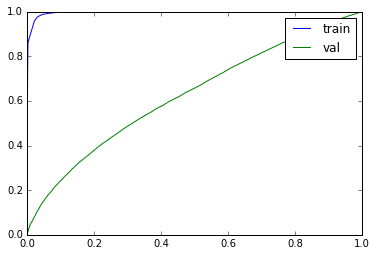

In [9]:
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import roc_curve


for source_i, Xi,Yi in [
                            ["train",Xtr,Ytr],
                            ["val",Xval,Yval]
                                ]:
    
    # Предскажем вероятность сгорания
    Yi_pred_proba = model.predict_proba(Xi)[:,1]
    
    #Поделим предсказание на сгоревшие и не сгоревшие
    Yi_pred_class = np.argsort(Yi_pred_proba) < 10000
    
    auc = roc_auc_score(Yi,Yi_pred_proba)
    acc = accuracy_score(Yi,Yi_pred_class)
    
    print '%s: \t AUC = %.5f \t Accuracy = %.5f'%(source_i, auc, acc)
    
    fpr,tpr,_ = roc_curve(Yi,Yi_pred_proba)
    
    plt.plot(fpr,tpr,label = source_i)
    
plt.legend()


# Отгрузим решение в файл

In [13]:
def generate_submission(preproc_fun,model,filename="submission.csv"):
    
    data_eval = pd.DataFrame.from_csv("./test.csv")
    
    
    x_col = [ 'dist','due', 'lat','lon','f_class','s_class','t_class',]
    X_eval = preproc_fun(data_eval[x_col])
    
    # Предскажем вероятность сгорания
    Y_pred_proba_eval = model.predict_proba(X_eval)[:,1]
    
    #Поделим предсказание на сгоревшие и не сгоревшие по порогу (thr)
    
    
    response = pd.DataFrame()
    response["Ids"] = np.arange(len(Y_pred_proba_eval))
    
    response["Y_prob"] = map("{0:.5f}".format,Y_pred_proba_eval)
    
    
    response.to_csv(filename,index=None)

In [14]:
generate_submission(preprocess_data,model,"submission.csv")

# Советы по улучшению модели:

* Смотри глазами на данные - строй графики, исследуй аномалия 
 * это может принести новые идеи и отбросить нежизнеспособные намного раньше 
 * Туториал по библиотеке, в которой можно строить графики 
   * http://matplotlib.org/users/pyplot_tutorial.html
 * Ключевой вопрос самому себе - __"От чего ещё может зависеть, сгорит ли заказ?"__


* Попробуй более точно настроить модель или выбрать другую
 * Random Forest с текущими параметрами можно улучшить
   * Документация по нему - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
 * А можно использовать другие, более подходящие методы
   * Документация по методам - http://scikit-learn.org/stable/supervised_learning.html
 * Наконец, модели можно комбинировать
   * Например, усреднять с весами
   * В итоге качество может быть лучше, чем у каждой модели по отдельности
 * Важно не увлечься - зачастую качественные изменения решения намного лучше подкручивания параметров


* Подумай, какие ещё дополнительные данные можно провязать с выборкой? 
 * насколько реально применить их за отведённое время?


* __Главное__ - пытайся понять, дадут ли твои улучшения прирост на новых данных
 * Тестовая выборка находится по времени дальше, чем обучающая.
   * Например, нельзя использовать номер дня в году, потому что мы обучаемся на выборке __ДО__ начала контрольной
 * Это не значит, что нужно отправлять миллион решений на проверку и выбирать лучшее - это приведёт к переобучению
 